In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.misc

import tensorflow as tf

import utils

## Начальная настройка

In [2]:
FROZEN_FPATH = 'data/frozen.pb' # ADJUST
INPUTE_NODE = 'net/input:0' # ADJUST
OUTPUT_NODE = 'net/fc8/BiasAdd:0' # ADJUST
CLASSES = ['Cat', 'Dog'] # ADJUST
CROP_SIZE = (224, 224) # ADJUST

## Загружаем то, что морозили в другом файле

In [3]:
graph_def = tf.GraphDef()
with tf.gfile.GFile(FROZEN_FPATH, "rb") as f:    
    graph_def.ParseFromString(f.read())
    
graph = tf.Graph()
with graph.as_default():
    net_inp, net_out = tf.import_graph_def(
        graph_def, return_elements=[INPUTE_NODE, OUTPUT_NODE])
    
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = True
sess = tf.Session(graph=graph, config=sess_config)

## Готовим изображения к распазнованию 

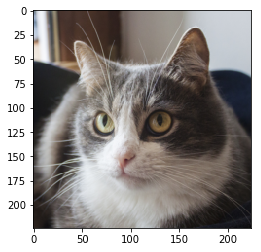

In [4]:
INPUT_IMAGE_FPATH = 'img/image.png'
# INPUT_IMAGE_FPATH = 'imagenet/val/ILSVRC2012_val_00004422.JPEG'
# INPUT_IMAGE_FPATH = 'imagenet/val/ILSVRC2012_val_00002708.JPEG'

def prepare_image(img_in, crop_size):
    img = img_in.astype(np.float32)
    img = utils.resize_and_crop(img, crop_size)    
    img = img[None, ...]
    return img

img = scipy.misc.imread(INPUT_IMAGE_FPATH, mode='RGB')
img = prepare_image(img, CROP_SIZE)
_=plt.imshow(img[0, ...]/255.)

## Котик или Собачка? Вот ответ

In [5]:
out = sess.run(net_out, feed_dict={net_inp: img})

print('Prediction: {}'.format(CLASSES[np.argmax(out)]))

Prediction: Cat


## Считаем точность 

In [6]:
import data_provider
image_list, label_list = data_provider.prepare_sample_list(
        'imagenet/val/','imagenet/val.txt',classes=[281, 239])

correct = 0
for img_fpath, label in zip(image_list, label_list):
    img = scipy.misc.imread(img_fpath, mode='RGB')
    img = prepare_image(img, CROP_SIZE)
    out = sess.run(net_out, feed_dict={net_inp: img})
    if np.argmax(out) == label:
        correct += 1
        
accuracy = float(correct) / len(image_list)
print('Accuracy: {}'.format(accuracy))

Accuracy: 0.97


## Время на 1 итерацию

In [8]:
%%timeit -n 10 -r 10

out = sess.run(net_out, feed_dict={net_inp: img})

8.35 ms ± 265 µs per loop (mean ± std. dev. of 10 runs, 10 loops each)
